In [2]:
import skewtfit as sf
from CentralStreamingModel.utils.plot_tools import bestfit_jointplot
import CentralStreamingModel.biskewt.skewt as st
import matplotlib.pyplot as plt
import numpy as np
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection.wrap_projection import skewt_los_pdf
from scipy.integrate import simps, quadrature, quad, dblquad

In [8]:
n_boxes = range(1,16)
boxsize = 2000
snapshot = 20

measured = VD_los('halos', 10, boxsize, snapshot)

In [9]:
measured.r.r

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
       44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
       55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
       66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
       77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
       88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
       99.5])

In [2]:
n_boxes = range(1,16)
boxsize = 2000
snapshot = 20

rs = []
for i, box in enumerate(n_boxes):

    rs.append(VD('halos',box, boxsize, snapshot))


In [3]:
jointpdf_rt = [halo.jointpdf for halo in rs]

mean_jointpdf_rt = np.mean(jointpdf_rt, axis=0)

In [4]:

    
popt, pcov = sf.radial_tangential_skewtfit(rs[0].r,
        rs[0].v.r, rs[0].v.t, mean_jointpdf_rt, log=False)
    


/home/c-cuesta/CentralStreamingModel/biskewt/skewt.py:17: RuntimeWarning: invalid value encountered in power
  postfactor = (1. + Q/dof)**(-(dof + 2.)/2.)
/home/c-cuesta/CentralStreamingModel/biskewt/skewt.py:24: RuntimeWarning: invalid value encountered in sqrt
  return alpha * ( (v[:,1] - vr_c) / np.sqrt(w_r)) * ((dof + 2)/(Q + dof)) ** 0.5
/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/c-cuesta/CentralStreamingModel/biskewt/skewt.py:15: RuntimeWarning: inv

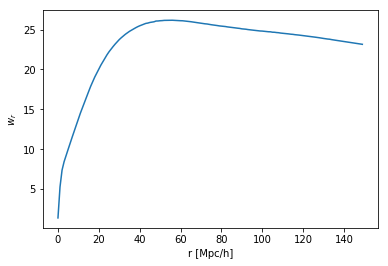

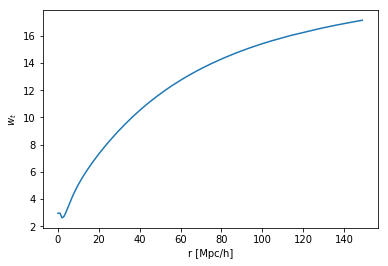

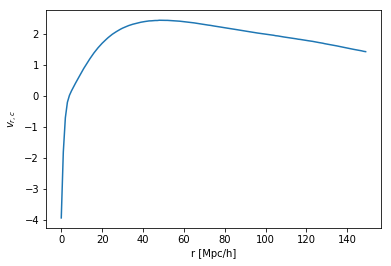

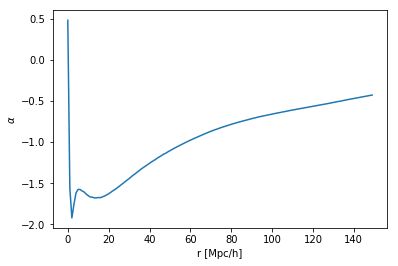

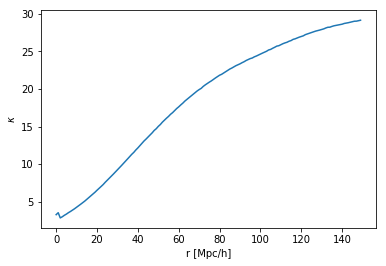

In [5]:
parameter_list = ['$w_r$', '$w_t$', '$v_{r,c}$', r'$\alpha$', '$\kappa$']

for i, parameter in enumerate(parameter_list):
    plt.plot(popt[:,i])


    plt.xlabel('r [Mpc/h]')
    plt.ylabel(parameter_list[i])
    plt.show()

# Check normalization of P(vr, vt | r)

In [6]:
# with simpson
rbin = 10

vr = np.linspace(-60.,60.,500)
vt = vr

v = np.array(np.meshgrid(vr, vt)).T.reshape(-1,2)

sample_skewt = st.skewt(v, *popt[rbin]).reshape(vt.shape[0], vr.shape[0])

simps_norm = simps(simps(sample_skewt, vr, axis=-1), vt, axis=-1)


In [7]:

def dblquad_integrand(vr, vt):
    v = np.expand_dims(np.array([vr, vt]), axis = 0)
    return st.skewt(v, *popt[rbin])[0]

In [8]:
dblquad_norm = dblquad(dblquad_integrand, -np.infty, np.infty, lambda x: -np.infty, lambda x:np.infty )


In [9]:
print('********* RADIAL/TANGENTIAL PDF ***************')
print(f'Simpsons norm : {simps_norm:.5f}')
print(f'Quad norm : {dblquad_norm[0]:.5f}, with error = {dblquad_norm[1]:.2E}')

********* RADIAL/TANGENTIAL PDF ***************
Simpsons norm : 0.99994
Quad norm : 1.00000, with error = 1.40E-08


# Check normalization of P(vlos | rperp, rparal)

In [45]:
r = np.sqrt(100**2 + 100**2)
print(r)

141.4213562373095


## Qagi (inf) to project

In [6]:
jointpdf_los =  skewt_los_pdf(rs[0].r, popt)

In [7]:
#rperp = 18.5
#rpar = 12.4

#rperp = 26.5
#rpar =17.5

rperp = 33.5
rpar =22.5

def skewt(vlos):
    return [jointpdf_los(rperp, rpar,v) for v in vlos]

def skewt_quad(vlos):
    return jointpdf_los(rperp, rpar,vlos)

In [8]:
vlos = np.linspace(-20., 20., 100)

st_quadrature = quadrature(skewt, -20.,20.)

st_quad = quad(skewt_quad, -np.infty, np.infty)

In [9]:
print('From (-20,20)')
print(f'ST : {simps(skewt(vlos), vlos):.5f}')
print(f'ST Quadrature : {st_quadrature[0]:.5f} (with error {st_quadrature[1]:.2E})')
print('From (-Inf,Inf)')
print(f'ST Quad : {st_quad[0]:.5f} (with error {st_quad[1]:.2E})')

From (-20,20)
ST : 0.99912
ST Quadrature : 0.99912 (with error 1.30E-08)
From (-Inf,Inf)
ST Quad : 0.99920 (with error 3.94E-10)


In [14]:
print('From (-20,20)')
print(f'ST : {simps(skewt(vlos), vlos):.5f}')
print(f'ST Quadrature : {st_quadrature[0]:.5f} (with error {st_quadrature[1]:.2E})')
print('From (-Inf,Inf)')
print(f'ST Quad : {st_quad[0]:.5f} (with error {st_quad[1]:.2E})')


From (-20,20)
ST : 0.99986
ST Quadrature : 0.99986 (with error 1.22E-08)
From (-Inf,Inf)
ST Quad : 1.00000 (with error 1.95E-09)


## Cquad to project

In [18]:
jointpdf_los =  skewt_los_pdf(rs[0].r, popt)

In [19]:
#rperp = 18.5
#rpar = 12.4

#rperp = 26.5
#rpar =17.5

rperp = 33.5
rpar =22.5

def skewt(vlos):
    return [jointpdf_los(rperp, rpar,v) for v in vlos]

def skewt_quad(vlos):
    return jointpdf_los(rperp, rpar,vlos)

In [20]:
vlos = np.linspace(-20., 20., 100)

st_quadrature = quadrature(skewt, -20.,20.)

st_quad = quad(skewt_quad, -np.infty, np.infty)

In [21]:
print('From (-20,20)')
print(f'ST : {simps(skewt(vlos), vlos):.5f}')
print(f'ST Quadrature : {st_quadrature[0]:.5f} (with error {st_quadrature[1]:.2E})')
print('From (-Inf,Inf)')
print(f'ST Quad : {st_quad[0]:.5f} (with error {st_quad[1]:.2E})')


From (-20,20)
ST : 0.99986
ST Quadrature : 0.99986 (with error 1.22E-08)
From (-Inf,Inf)
ST Quad : 1.00000 (with error 1.95E-09)


## Streaming integral after qagi projection

In [ ]:
jointpdf_los =  skewt_los_pdf(rs[0].r, popt)

In [36]:
r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)
        return p

    st_quad_left = quad(define_integrand, -70, 0.)
    st_quad_right = quad(define_integrand, 0., 70.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quad_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')


(r_perp = 18.5, r_par = 12.6 )
1.03117 (with error = 1.01E-08 )
(r_perp = 26.5, r_par = 17.5 )
1.01493 (with error = 6.08E-09 )
(r_perp = 33.5, r_par = 22.5 )
1.00753 (with error = 1.17E-08 )


## Streaming integral after qagi projection + more r parallel range (from 70 to 100)

In [15]:
r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)
        return p

    st_quad_left = quad(define_integrand, -100, 0.)
    st_quad_right = quad(define_integrand, 0., 100.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quad_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')


(r_perp = 18.5, r_par = 12.6 )
1.03117 (with error = 1.35E-08 )
(r_perp = 26.5, r_par = 17.5 )
1.01493 (with error = 6.22E-09 )
(r_perp = 33.5, r_par = 22.5 )
1.00753 (with error = 1.08E-08 )


## Streaming integral after qagi projection + renormalizing

In [37]:
r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def skewt_quad(vlos, rperp, rpar):
        return jointpdf_los(rperp, rpar,vlos)

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)/quad(skewt_quad, -20.,20.,args=(rperp, abs(y_value)))[0]
        return p

    st_quad_left = quad(define_integrand, -70, 0.)
    st_quad_right = quad(define_integrand, 0., 70.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quadf_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')


(r_perp = 18.5, r_par = 12.6 )
1.03170 (with error = 1.01E-08 )
(r_perp = 26.5, r_par = 17.5 )
1.01517 (with error = 6.13E-09 )
(r_perp = 33.5, r_par = 22.5 )
1.00768 (with error = 1.21E-08 )


In [38]:
r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def skewt_quad(vlos, rperp, rpar):
        return jointpdf_los(rperp, rpar,vlos)

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)/quad(skewt_quad, -40.,40.,args=(rperp, abs(y_value)))[0]
        return p

    st_quad_left = quad(define_integrand, -70, 0.)
    st_quad_right = quad(define_integrand, 0., 70.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quad_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')


(r_perp = 18.5, r_par = 12.6 )
1.03118 (with error = 1.01E-08 )
(r_perp = 26.5, r_par = 17.5 )
1.01493 (with error = 6.08E-09 )
(r_perp = 33.5, r_par = 22.5 )
1.00753 (with error = 1.17E-08 )


In [39]:
r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def skewt_quad(vlos, rperp, rpar):
        return jointpdf_los(rperp, rpar,vlos)

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)/quad(skewt_quad, -15.,15.,args=(rperp, abs(y_value)))[0]
        return p

    st_quad_left = quad(define_integrand, -70, 0.)
    st_quad_right = quad(define_integrand, 0., 70.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quad_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')

(r_perp = 18.5, r_par = 12.6 )
1.03381 (with error = 9.98E-09 )
(r_perp = 26.5, r_par = 17.5 )
1.01665 (with error = 6.29E-09 )
(r_perp = 33.5, r_par = 22.5 )
1.00892 (with error = 1.37E-08 )


## Streaming integral after cquad projection from (-20,20) and renormalizing

In [10]:
jointpdf_los =  skewt_los_pdf(rs[0].r, popt)

r_pairs = [[18.5, 12.6], [26.5, 17.5], [33.5, 22.5]]

for r in r_pairs:
    rperp = r[0]
    rpar = r[1]

    def skewt_quad(vlos, rperp, rpar):
        return jointpdf_los(rperp, rpar,vlos)

    def define_integrand(y_value):

        vlos = (rpar - y_value) * np.sign(y_value)

        p = jointpdf_los(rperp, abs(y_value), vlos)/quad(skewt_quad, -20.,20.,args=(rperp, abs(y_value)))[0]
        return p

    st_quad_left = quad(define_integrand, -70, 0.)
    st_quad_right = quad(define_integrand, 0., 70.)
    print(f'(r_perp = {rperp}, r_par = {rpar} )')
    print(f'{st_quad_left[0] + st_quad_right[0]:.5f} (with error = {st_quad_right[1]:.2E} )')

(r_perp = 18.5, r_par = 12.6 )
1.03258 (with error = 1.49E-08 )
(r_perp = 26.5, r_par = 17.5 )
1.01601 (with error = 1.49E-08 )
(r_perp = 33.5, r_par = 22.5 )
1.00824 (with error = 1.09E-08 )


## Streaming integral after cquad projection from renormalizing (-20,20) 